In [82]:
# Load in the relevant packages
import sympy

#INTERESING COMPARISONS?
# 1. Journal of Physics and Chemistry of Solids 65 (2004) 1077–1081
# I doupt their units are correct...
#
# 2. Pedone
# O-O 0.042395 1.379316 3.618701 22.0
# Ba-O 0.065011 1.547596 3.393410 5.0

def assign_params(st,dict):
        for key in dict:
                st = st.replace(key, str( dict[key] ))
        return st

def evaluateG2B(V,r):
       Vofr=[]
       V=sympy.sympify(V)
       for rs in r:
                f_eval=V.subs({'r_ij':rs})
                Vofr.append( f_eval.evalf())
       return Vofr   

params={}
V={}

pairs=["Ba-O","O-O"]
charge_dict={"Ba":2.0,"O":-2.0}
V_ij="D_ij*(1-exp(a_ij*(r_ij-r_0))**2 - 1) + C_ij/(r_ij**12)"
params["Ba-O"]={"D_ij":0.065011, "a_ij": 1.547596,"r_0": 3.393410,"C_ij": 5.0}
params["O-O"] = {"D_ij":0.042395, "a_ij": 1.379316,"r_0": 3.618701,"C_ij": 22.0}


for pair in pairs:
       V[pair]= assign_params(V_ij,params[pair])
       

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt

LJ=bulk('BaO','rocksalt',cubic=True,a=5.55)

### Generate input.json file
import json

input={
        "Charge scaling factor": 1.0,
        "One_body": {
                "Ba": 0.0
        },
        "Two_body": {
                "Ba-O": {
                        "r_min": 0.0,
                        "r_cut": 12.0,
                        "V_func" : V["Ba-O"]
                },
                "O-O": {
                        "r_min": 0.0,
                        "r_cut": 12.0,   
                        "V_func" : V["O-O"]
                }
        }
}

#SAVE TO FILE
with open('G2B_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [76]:
from ccs_fit.ase_calculator.ccs_ase_G2B import G2B
calc = G2B(G2B_params=input,charge=True,q={"Ba":1.2,"O":-0.6},charge_scaling=False)
LJ.calc=calc

In [77]:
orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude=0.02
disp_steps=5
rounds=2

trainset_list="file_list" # List of strucutres to include in the database (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.95, 1.05, 6):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i, seed=counter)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            if nrg < 0: # We exclude structures that are unreasonably high in energy
                xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
                write(xyz_file,rattle_struc)
                print(xyz_file,file=f)
                counter += 1

f.close()

c:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


In [62]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="LJ.db",file_list="file_list",overwrite=True)

    Building data-bases: 100%|██████████| 60/60 [00:01<00:00, 37.49it/s]


In [84]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS+Q",DFT_DB="LJ.db",include_forces=True,charge_dict=charge_dict,R_c=12)

    Fetching data: 100%|██████████| 60/60 [00:02<00:00, 27.84it/s]


In [85]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "True"
    },
    "Twobody": {
                "Ba-O": {
                        "Rcut": 12.0,
                        "Resolution": 0.5,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "O-O": {
                        "Rcut": 12.0,
                        "Resolution": 0.5,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [86]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Ba', 'O']
    Applying monotonic constraints for pair:  Ba-O
    Applying monotonic constraints for pair:  O-O
    Merging intervals for pair Ba-O; number of intervals reduced from 21 to 19. 
    Merging intervals for pair O-O; number of intervals reduced from 19 to 18. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O


    Finding optimum switch: 100%|██████████| 342/342 [00:00<00:00, 398.72it/s]

    The best switch is (15, 3) with rmse: 0.0740952090219064, corresponding to distances of [9.53 4.63] Å for element pairs ['Ba-O', 'O-O'].



C:\Users\jolku587\PGMS\CCS\src\ccs_fit\fitting\spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)


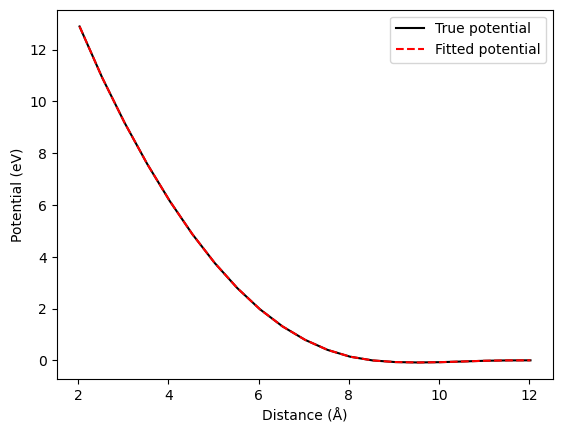

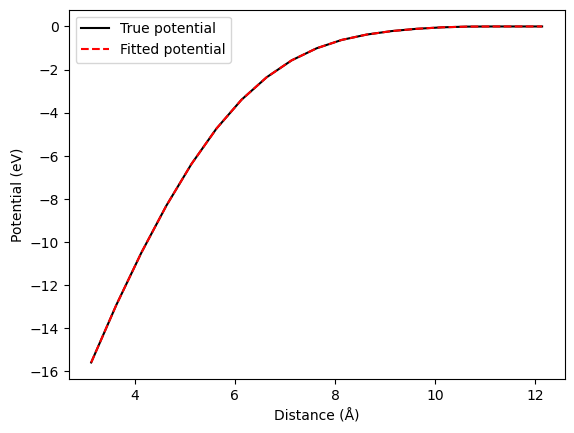

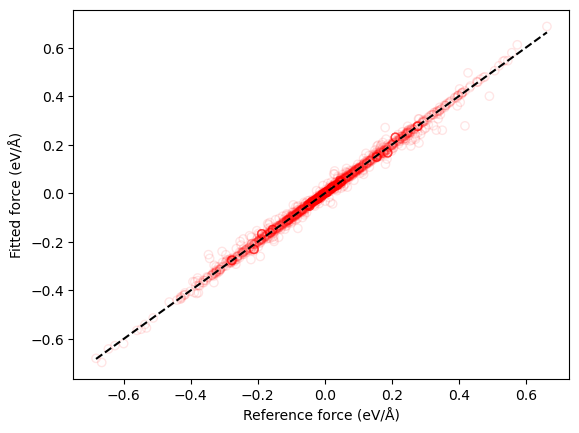

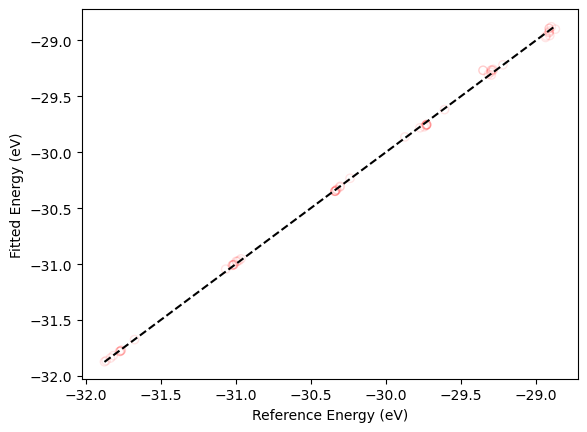

In [87]:
with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

for pair in pairs:
    r=np.array(CCS_params["Two_body"][pair]["r"])
    e=CCS_params["Two_body"][pair]["spl_a"]
    e_ref=evaluateG2B(V[pair],r)
    plt.xlabel('Distance (Å)')
    plt.ylabel('Potential (eV)')
    plt.plot(r,e,color='black',label="True potential")
    plt.plot(r,e,'--',color='red',label="Fitted potential")
    plt.legend()
    plt.show()

err_F=np.loadtxt("CCS_error_forces.out")
plt.xlabel('Reference force (eV/Å)')
plt.ylabel('Fitted force (eV/Å)')
plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
plt.show()

err_F=np.loadtxt("CCS_error.out")
plt.xlabel('Reference Energy (eV)')
plt.ylabel('Fitted Energy (eV)')
plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
plt.show()
